# Introduction

Like most sports these days, the top levels of motorsport are very data rich and data driven. Formula 1 in particular champions many groundbreaking developments in data science, such as the ability to stream large amounts of data quickly to the pit wall and back to the team's home factories for further analysis during on-track sessions (practice, qualifying, and the race itself). In the role of a race strategy engineer, it is imperative to develop an effective data driven approach to plan out a race weekend and strategy, while also being able to translate observed on-track activity, factor in changing track and weather conditions, and understand the impact each driver and car has on the data collected. 

There are no shortage of applications, packages, and algorithms to feed data into and return a value or set of values. While the power of these methods should not be understated, I believe that teams are on a level playing field in this regard. However, I would argue that differences can be made by having appropriate domain knowledge along with effective communication and understanding amongst the different stakeholders of the team to develop powerful features to feed into whatever models are chosen. Being able to translate what happens on track into features that can be incorporated into a predictive model is what gives strength and confidence for the computer predicted value returned. 

As an example, a machine learning algorithm can take a driver's previous ten laps as feature inputs to return a projected lap time for the eleventh lap. Every team has access to the lap times, and would be able to run the same model. However, this approach fails to take into account the many other confounding variables that can influence a lap time. Perhaps the driver was stuck in traffic behind other cars, or they pushed too hard in the early laps and degraded their tyres too much. 

This report outlines my approach and thought process behind developing feature inputs based on existing data, and buliding two predictive models for the example above. Then the effectiveness of these features and models will be evaluated against observed data from an actual race (2021 Azerbaijan Grand Prix). 

## Methods

To illustrate the feature development and predictive modeling workflow, the fastf1 api package was utilized to query lap time data from the 2021 Azerbaijan Grand Prix. During this race, the Aston Martin of Sebastian Vettel was able to secure a P2 result after the team. This result was laregly in part to the strategy deployed by the team, especially early in the race when the first round of pit stops took place. Vettel was able to extend his first stint much longer than his opponent Yuki Tsunoda ahead of him, and was able to conserve his tyres and find pace when needed allowing him to jump positions after all the cars pitted. 

While the models developed and deployed by the teams have much more data at their disposal to incorporate, the same approach can be taken to make use of existing data elements and interpolate them in different ways to try and improve projection confidence. Additionally, teams can use data from practice and sessions as inputs for their models. 

### Data Collection
The fastf1 api package provides the abiltity to query race lap time data from a database. The documentation can be found here().

The data output from the query includes many variables, but this analysis will make use of the timing data in particular (lap times for each lap per driver). 


### Data Transformation and Feature Development

After querying the raw data, the output was exported and loaded into a SQLite database for transformation. While the same transformations can be made with pandas, numpy and other python packages, SQLite/DBBrowser allows for efficient database development and intuitive joining and transformation workflow. 

From the raw data, a series of feature inputs for the predictive models were developed. This was done with the overarching principle of calculating deltas and aggregating sums per driver. 

Generating features that are appropriately weighted allows for the projection to be unique to what each driver and car are capable of. Grouping the data by driver to calculate the values for the variables above allows for the predictions to reflect the characteristics of the driver themselves. Because the driver is ultimately the one piloting the car, their own characteristics and skillset is reflected in the data fed into the model via the relative time delta calculations.


### Predictive Modeling

Once the features were developed, the data was fed into two different regression algorithms. 
   - Multiple Linear Regression
   - XGBoost Regression

Since the target variable to be predicted is continuous (lap time in seconds), regression is the appropriate approach to take. 

With how data rich the sport is, I think the difference can be made in how the data avaliable is interpreted. While the discussion about what model to fit or algorithm to use is certainly important, I believe that developing features by interpolating existing data is key to bridging the gap between a computer generated prediction and what is observed on track. 

### Key Concepts

The tyre compound each driver was on will be used as feature inputs for the model, as they have a direct impact on performance. 

There are three tyre compounds a team can choose to fit on their car during a race:
   - Soft (Red) - allows for faster laps/more grip but high rate of degradation and sooner drop off in performance
   - Hard (White) - slower laps/less grip, but lower rate of degradation and allows for driver to stay on track longer before coming into the pits to change out for a new fresh set
   - Medium (Yellow) - balanced tyre out of the three, in the middle in regard to grip level/rate of degradation

One other element to consider is that during a race, a team must use at least two different tyre compounds.

Therefore, it is crucial to determine the best tyre compound to fit and when in order to maximize the race result.

In [2]:
# load packages 
import fastf1 as ff1
import pandas as pd
from fastf1 import plotting
from matplotlib import pyplot as plt
import datetime as dt
import plotly.express as px
import seaborn as sns
import scipy

## Lap Time Prediction

Being able to project a driver's lap time given a set of parameters would be a valuable tool for a team, especially when trying to determine the right time to call the driver into the pits. Of course, the value and strength of this tool is determined by the feature inputs used to train it. 


### Lap Time Prediction - Data Collection

As performed earlier, I'll use the fast-f1 package to query data from the 2021 Azerbaijan Grand Prix. Then, I'll use SQL to transform and prep the data before building the model.

In [3]:
# load 2021 grand prix
baku_21 = ff1.get_session(2021, 'Baku', 'R')
baku_21 = baku_21.load_laps(with_telemetry=True)
baku_21 = pd.DataFrame(data = baku_21)

core           INFO 	Loading Azerbaijan Grand Prix - Race
api         WARNING 	

NO CACHE! Api request caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api         WARNING 	Driver 47: Ignoring late data for a previously processed lap.The data may contain errors (previous: 42; current 43)
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
utils          INFO 	NumExpr defaulting to 6 threads.
api            INFO 	Fetching track status data...
api            INFO 	Fetching car data...
api            INFO 	Parsing car data...
api            INFO 	Fetching position data...
api            INFO 	Parsing position data...
api         WARNING 	Driver 241: Position data is incomplete!
api         WARNI

In [5]:
# drop naT times
baku_21 = baku_21.dropna(subset=['LapTime'])
baku_21['Seconds'] = baku_21['LapTime'].dt.total_seconds()
baku_21['LapStartSeconds'] = baku_21['LapStartTime'].dt.total_seconds()
baku_21['PitWindowTime'] = baku_21['LapStartSeconds'] + 25.42234783 
baku_21.to_csv('baku_21_r.csv')
#baku_21 = pd.read_csv('baku_21_r.csv')

### Lap Time Prediction - Data Transformation

The data preparation process involved calculating different sets of time deltas (in seconds). I think that a useful utility for a team would be one that is straightforward to implement, and incorporates feature inputs that are concrete yet simple. For the following model, lap time will be predicted based on a set of parameters.

Building a more robust and effective model would be dependent on the data accessible. However, using the data that is published publicly (mainly lap times), I've created variables that I think would be important to consider when evaluating the pace of a car/driver during a race.


### Created Features
- Rolling Lap Time Average
    - For each lap, what is the average lap time for that driver until that point?
        - This gives a sense of the general race pace of the driver.
- Rolling Fastest Lap
    - For each lap, what was the fastest lap put in by that driver until that point?
        - This gives the maximum pace of the driver at this stage of the race.
- Faster Than Last Lap + Aggregating Sum
    - Was the lap just completed faster than their previous lap? (1 = yes, 0 = no)
        - Insight to driver pushing more than their previous lap
    - Faster Than Last Lap Sum (each lap that returns 1 is summed)
        - Quantifies the number of laps that the driver is increasing relative pace
- Faster Than Rolling Lap Time Average + Aggregating Sum
    - Was this lap faster than the average times of the previous lap? (1 = yes, 0 = no)
        - Insight to driver improving pace relative to stint 
    - Faster than Average Lap Sum (each lap that returns 1 is summed)
        - Gives insight as to how much driver is pushing over stint
- New Fast Lap Counter (1 = yes, 0 = no)
    - Counts how many times driver puts in lap better than personal best
        - Quantifies max pace laps during stint


These features are simple to calculate, however I feel that they could be powerful in determining the lifespan of a set of tyres before the degradation drop off. A team could effectively enter values based on the data they have access to, and determine if future laps are projected to be faster/slower than their target. These values could also be determined from the practice sessions. A target average lap and target fastest lap on each tyre compound could be taken from observations during practice.

In [4]:
## load data
baku_21_pred = pd.read_csv('baku_lap_deltas_l9.csv')
baku_21_pred

,DriverNumber,LapNumber,soft_compound,medium_compound,hard_compound,tyrelife,last_lap_delta,faster_than_last,faster_than_avg,rolling_lt_avg,rolling_fastest_lap,faster_than_avg.1,new_fastest_l,new_fastest_l_sum,faster_avg_sum,faster_last_sum,laptime
0,3,3,1,0,0,3.0,-0.726,1,1,110.972000,110.972,1,1,1,1,1,110.246
1,3,4,1,0,0,4.0,-1.611,1,1,110.609000,110.246,1,1,2,2,2,108.635
2,3,5,1,0,0,5.0,-0.234,1,1,109.951000,108.635,1,1,3,3,3,108.401
3,3,6,1,0,0,6.0,-0.146,1,1,109.563500,108.401,1,1,4,4,4,108.255
4,3,7,1,0,0,7.0,0.683,0,1,109.301800,108.255,1,0,4,5,4,108.938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,99,7,0,0,1,5.0,-0.081,1,1,113.696600,108.592,1,0,2,4,3,108.703
157,99,8,0,0,1,6.0,-0.063,1,1,112.864333,108.592,1,0,2,5,4,108.640
158,99,9,0,0,1,7.0,-0.402,1,1,112.260857,108.592,1,1,3,6,5,108.238
159,99,10,0,0,1,8.0,0.069,0,1,111.758000,108.238,1,0,3,7,5,108.307


In [10]:
## example data - seb
seb_example = baku_21_pred[baku_21_pred["DriverNumber"]==5]
seb_example

,DriverNumber,LapNumber,soft_compound,medium_compound,hard_compound,tyrelife,last_lap_delta,faster_than_last,faster_than_avg,rolling_lt_avg,rolling_fastest_lap,faster_than_avg.1,new_fastest_l,new_fastest_l_sum,faster_avg_sum,faster_last_sum,laptime
18,5,3,1,0,0,3.0,-1.137,1,1,110.157000,110.157,1,1,1,1,1,109.020
19,5,4,1,0,0,4.0,-0.593,1,1,109.588500,109.020,1,1,2,2,2,108.427
20,5,5,1,0,0,5.0,0.360,0,1,109.201333,108.427,1,0,2,3,2,108.787
21,5,6,1,0,0,6.0,-0.070,1,1,109.097750,108.427,1,0,2,4,3,108.717
22,5,7,1,0,0,7.0,-0.287,1,1,109.021600,108.427,1,0,2,5,4,108.430
23,5,8,1,0,0,8.0,-0.241,1,1,108.923000,108.427,1,1,3,6,5,108.189
24,5,9,1,0,0,9.0,0.938,0,0,108.818143,108.189,0,0,3,6,5,109.127
25,5,10,1,0,0,10.0,-1.469,1,1,108.856750,108.189,1,1,4,7,6,107.658
26,5,11,1,0,0,11.0,-0.384,1,1,108.723556,107.658,1,1,5,8,7,107.274


### Example of Created Features

The model will calculate two projections, each using data avaliable at the stage of the race a decision needed to be made. This will be done to simulate the conditions teams face during the race. 

First, the Aston Martin needed to decide whether to pit Sebastian Vettel (P8) after the car ahead, Yuki Tsunoda (P7) pitted for the first time on lap 9. At this point in the race, the question is whether Vettel will be faster on older tyres than Tsunoda would be on newer tyres in the coming laps (laps 10 and 11). If Vettel is projected to be slower, then the best option would be to come into the pits the next lap and counter Tsunoda's move. However, if Vettel is projected to be faster, maintaining track position and pitting later would allow him to jump Tsunoda's position.  

I have subsetted the data to show Sebastian Vettel's laps at this stage of the race. Looking through the columns, it can be observed that the rolling_lt_avg changes each lap as a new lap time is added. However, the rolling_fastest_lap only changes if a new fastest lap is set. The columns ending with the suffix "sum" denote 1 if the lap time for each lap was faster than the existing average, existing fastest lap, and if it was faster than the last lap. 

By using rolling_lt_avg and rolling_fastest_lap as inputs, teams are able to project results that are relative to their own performance capabilities. 

### Lap Time Prediction - Multiple Regression

The first model that the data will be run through is a simple Multiple Linear Regression model. This model aims to minimize the residual sum of squares between observations and target, and the final projection is generated by the best fit line.  

In [12]:
## for machine learning
from sklearn import linear_model

Not every column from the dataframe above will be used to generate a prediction. Since we have variables that are weighted equally for each driver, DriverNumber is not needed. 

Below, the data is split into the feature inputs and the target output (lap time in seconds). 

In [13]:
# split data set
regr = linear_model.LinearRegression()
X = baku_21_pred[['soft_compound', 'medium_compound','hard_compound','tyrelife','rolling_lt_avg','rolling_fastest_lap', 'new_fastest_l_sum','faster_avg_sum','faster_last_sum']]
y = baku_21_pred['laptime']

In [15]:
# fit model
regr.fit(X, y)

LinearRegression()

### Lap Time Prediction - Projection 

The model has been fit via sklearn linear model. 

To project a lap time in seconds, data needs to be entered as an array. This array takes the feature inputs in the same order declared above. 

As an example, the lap time of Sebastian Vettel's twelveth lap will be projected based. Data from the eleventh lap will be used as the feature inputs for the projection.

In [21]:
# input takes array with features in same order as df
#X = baku_21_pred[['soft_compound', 'medium_compound','hard_compound','tyrelife','rolling_lt_avg','rolling_fastest_lap', 'new_fastest_l_sum','faster_avg_sum','faster_last_sum']]
# use new inputs to predict lap time
predicted_laptime = regr.predict([[1,0,0,12,108.72, 107.658,5,8,7]])
print('Predicted: %.3f' % predicted_laptime )

Predicted: 104.745


### Lap Time Prediction - Projection Result

This model projected the lap time of 104.75 seconds for Lap 12. This indicates that Vettel's pace is projected to increase based on the feature inputs, supporting the decsion to keep him out on track longer and not pit right away. 

### Lap Time Prediction - Feature Coefficients

Now that the model has been fitted and tested, it is important to assess the power of each of our feature inputs, to see which of the variables gives more weight to the prediction compared to the others.

Feature: 0, Score: -1.41508
Feature: 1, Score: -1.04634
Feature: 2, Score: 2.46142
Feature: 3, Score: -0.80961
Feature: 4, Score: -1.85110
Feature: 5, Score: 1.84698
Feature: 6, Score: 0.28891
Feature: 7, Score: 2.03081
Feature: 8, Score: -2.42463


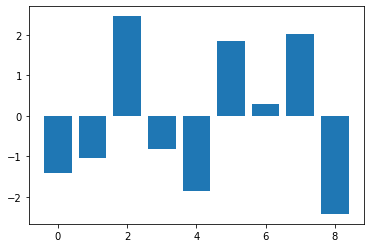

In [64]:
from matplotlib import pyplot
# importnt to determine feature selection
importance = regr.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Comparing the magnitude of the feature scores is relative to the data. Each feature score can be interpreted as the effect of adding a value of magnitude 1 to each feature. As an example, Feature 4 pertains to TyreLife. According to the model fit, an increase in TyreLife by 1 results in change of -1.8 seconds to the output value. 

While the convention is that an increase in TyreLife results in slower pace, could be due to the smaller sample size of data used to train the model. Additionally, while a three second decrease in lap time might be unrealistic in magnitude, it still shows that the trend is pointing towards faster lap times as the laps go on. This supports what was observed in the race, as Aston Martin elected to extend Vettel's first stint and keep him out on older tyres. Vettel's observed lap time was 107.065, consistent with the projection that Vettel could pick up the pace. He eventually jumped Tsunoda and pitted on Lap 18. 

### Lap Time Prediction - XG Boost

To compare model efficacy to a more involved machine learning method, I'll be running the same data through the XG Boost algorithm.

XGBoost is an decision-tree-based algorithm that is capable of performing classification or regression even with medium to small data set sizes. This method was chosen because of the smaller dataset size avaliable at the beginning of a race. 

One of the key features that makes XG Boost powerful is gradient boosting. The algorithm trains a model over and over again, learning from mistakes made from each previous model's decision trees. 

XGBoost has plenty of tuning parameters, such as the amount of decision trees to be made, however we will use the default settings for the projection. 

Documentation on XGBoost can be found here (). 

### Lap Time Prediction - XG Boost Model Fitting/Validation

The data needs to be split into the input and output columns. Then the model is declared and data is fitted. 

In [24]:
Xg = X
yg = y

Xg = Xg.values
yg = yg.values

In [25]:
# load packages for XGB
from numpy import absolute
from numpy import asarray
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# define model
modelG = XGBRegressor()
# fit model
modelG.fit(Xg, yg)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Lap Time Prediction - XG Boost prediction

Following the same procedure as above, feature inputs have to be entered as an array in the same order as the columns are listed in the dataframe. 

In [70]:
values = ([1,0,0,12,108.72, 107.658,5,8,7])
new_data = asarray([values])
# make a prediction
yhat = modelG.predict(new_data)
# summarize prediction
print('Predicted: %.3f' % yhat)

Predicted: 107.191


The output from the XGBoost projection is 107.191 seconds for Vettel's lap 12. Recalling that the observed value is 107.065, being roughly a tenth off shows that XGBoost performs well with smaller data sets. 


### Lap Time Prediction - Feature Coefficients

Now that the model has been fitted and tested, it is important to assess the power of each of our feature inputs, to see which of the variables gives more weight to the prediction compared to the others.

Feature scoring is different for this model, as the feature's weight is plotted. A higher weight correspondds to higher importance in the model. 

<AxesSubplot:>

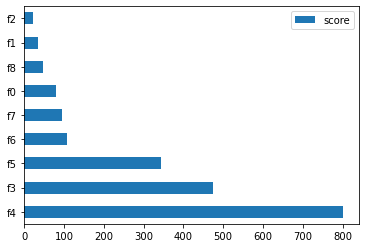

In [71]:
# feature importance 

feature_important = modelG.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

According to the plot above, feature 4 (rolling_lt_average) has the biggest impact on the model. This shows that the features generated from the raw data are useful in making predictions with this algorithm. 

## Limitations and Conclusion

As stated earlier, there are a number of limitations regarding the predictions made with both models and their real time application. Since both models theoretically would take live data fed from timing software trackside, the strength of the predictions would be dependent on the data avaliable at the time. For instance, if no teams were running the Hard compound early in the race, the strength of the prediction for lap times on the Hards would be impacted. It cannot be re-iterated enough that the strength of the model is dependent on the feature inputs. While data can certainly be imported from practice sessions, the trade off between real-time track conditions and representive data is something to consider. Conditions on track can evolve drastically, especially during the race (not including the impact of weather, wind, etc). 

Therefore, I argue that it is crucial for a team to approach model development with a priority in feature development and integration. Before bringing data into a model, how can a team take the existing data and transform/interpret it in a way that is useful. 

In this analysis, both model's feature importance plots show that the generated variable of rolling lap time average carries the strongest weight. While the tyre compound fitted is undoubtedly important, those feature inputs carried less weight. Looking at a race weekend comprehensively, practice sessions could be used to collect data to calculate a reasonable rolling lap time average and fastest lap. 

I am aware that there are many advanced utilities to simulate lap times such as RACE software, Canopy solutions, etc. However, these utilities still require feature inputs, and thinking creatively about how to interpolate raw data into useful inputs is where teams can generate gaps from others. 

A possible area of further exploration would be to generate a prediction of when a car will come into the pits, based on the same feature inputs. 
